# Solution to programming exercises week 5

INF2310, spring 2017

## Histogram equalization

In this week's exescise, we will show how to implement a histogram equalization, and apply it on some images.

In [304]:
% matplotlib inline

import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn

This function takes a graylevel image and an integer specifying the number of gray levels in the result image. Thanks to Kristine for providing a proposal (I have only changed some variable names, added a method docstring, and returned the transform).

In [305]:
def histeq(img, num_gl):
    """Computes a histogram equalization transform of the input image.
    
    Args:
        img: MxN numpy array of int. Input image that is to be transformed.
        num_gl: int. Number of graylevels in input image.
        
    Returns:
        trans_img: MxN numpy array of int. Histogram equalized image.
    """

    N, M = img.shape

    norm_hist = np.array([np.sum(img == g) for g in range(num_gl)])/(N*M)
    cumul_hist = np.array([np.sum(norm_hist[:g+1]) for g in range(num_gl)])

    transform = np.round((num_gl - 1)*cumul_hist).astype(int)
    trans_img = transform[img]
    
    return trans_img, transform

## Task 3

Let us test our function on the test image

$$
\begin{equation}
\begin{array}{|c|c|c|c|c|c|c|c|}
    \hline
    1 & 1 & 1 & 4 & 4 & 4 & 4 & 3 \\
    \hline
    1 & 1 & 1 & 2 & 2 & 3 & 2 & 2 \\
    \hline
    1 & 1 & 1 & 4 & 4 & 2 & 4 & 0 \\
    \hline
    1 & 1 & 1 & 2 & 3 & 3 & 4 & 0 \\
    \hline
    1 & 1 & 1 & 2 & 1 & 4 & 4 & 3 \\
    \hline
    4 & 1 & 2 & 1 & 1 & 1 & 1 & 1 \\
    \hline
    4 & 4 & 4 & 1 & 1 & 1 & 1 & 1 \\
    \hline
    4 & 2 & 4 & 3 & 2 & 4 & 4 & 0 \\
    \hline
\end{array}
\end{equation}
$$

In [306]:
img = np.array([[1, 1, 1, 4, 4, 4, 4, 3],
                [1, 1, 1, 2, 2, 3, 2, 2],
                [1, 1, 1, 4, 4, 2, 4, 0],
                [1, 1, 1, 2, 3, 3, 4, 0],
                [1, 1, 1, 2, 1, 4, 4, 3],
                [4, 1, 2, 1, 1, 1, 1, 1],
                [4, 4, 4, 1, 1, 1, 1, 1],
                [4, 2, 4, 3, 2, 4, 4, 0]])
trans_img, _ = histeq(img, 8)

print(trans_img)

[[3 3 3 7 7 7 7 5]
 [3 3 3 4 4 5 4 4]
 [3 3 3 7 7 4 7 0]
 [3 3 3 4 5 5 7 0]
 [3 3 3 4 3 7 7 5]
 [7 3 4 3 3 3 3 3]
 [7 7 7 3 3 3 3 3]
 [7 4 7 5 4 7 7 0]]


[ 3 27 10  6 18  0  0  0]


<Container object of 8 artists>

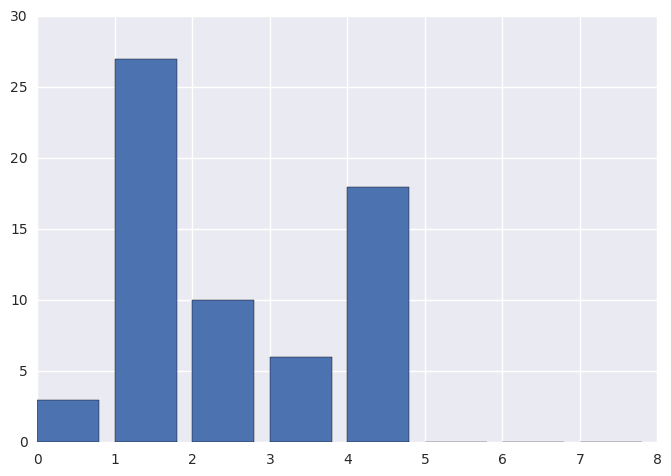

In [307]:
orig_hist, _ = np.histogram(img, bins=8, range=(0, 8))
print(orig_hist)
plt.bar(range(0, 8), orig_hist)

[ 3  0  0 27 10  6  0 18]


<Container object of 8 artists>

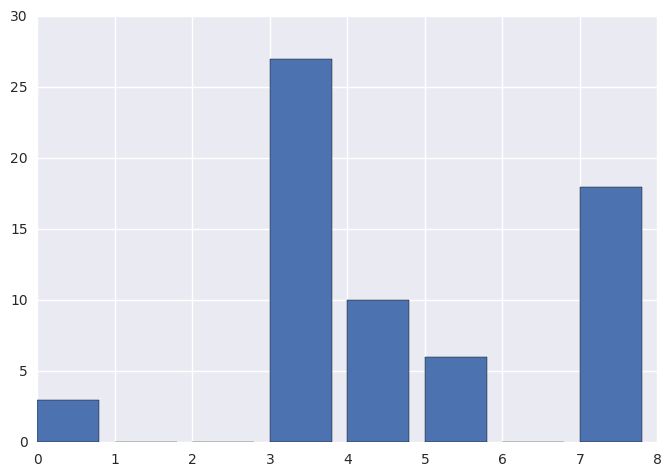

In [308]:
trans_hist, _ = np.histogram(trans_img, bins=8, range=(0, 8))
print(trans_hist)
plt.bar(range(0, 8), trans_hist)

## Task 5

In [309]:
# If you are going to compare this result to the one in the lecture slides,
# note that this image is not identical.
img = cv2.imread('../../assets/images/car.png', cv2.IMREAD_GRAYSCALE)
histeq_img, _ = histeq(img, 256)

(-0.5, 255.5, 255.5, -0.5)

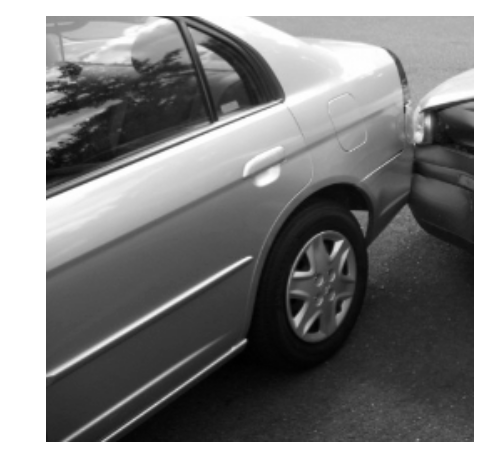

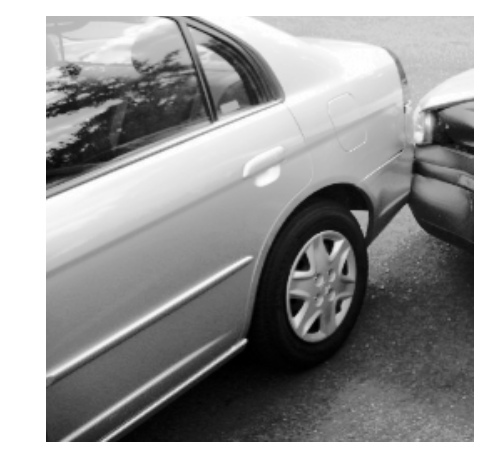

In [318]:
plt.figure(0)
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.figure(1)
plt.imshow(histeq_img, cmap='gray')
plt.axis('off')

<Container object of 256 artists>

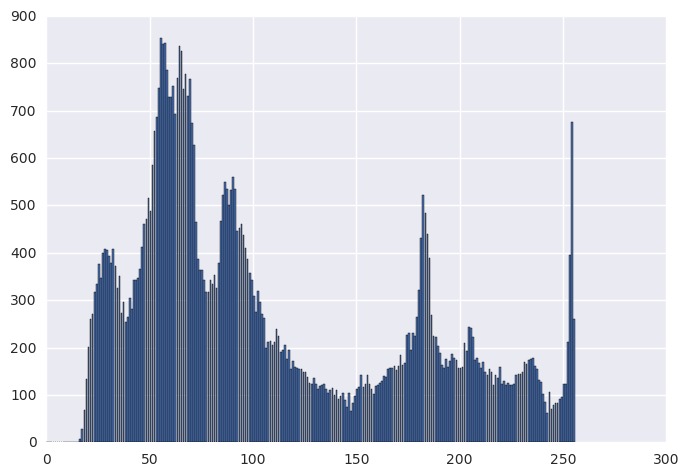

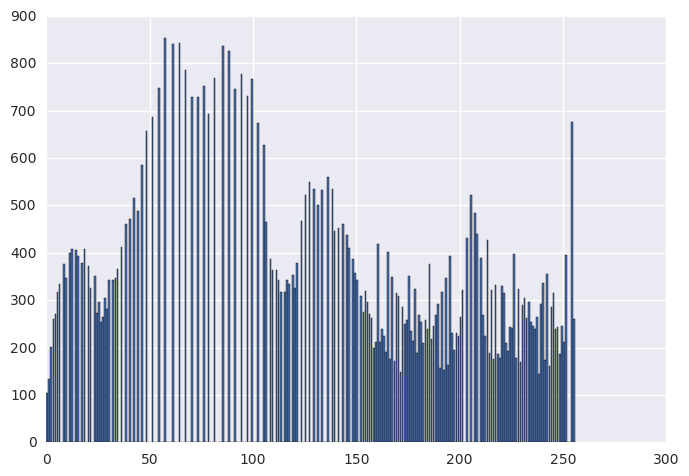

In [311]:
orig_hist, _ = np.histogram(img, bins=256, range=(0, 256))
histeq_hist, _ = np.histogram(histeq_img, bins=256, range=(0, 256))

plt.figure(0)
plt.bar(range(0, 256), orig_hist)
plt.figure(1)
plt.bar(range(0, 256), histeq_hist)

## Task 8

In this task, we will implement a histogram matching transform. We will try to match the normal distribution, but whatever other appropriate distribution can be used.

Let us first compute the Gaussian pmf and cmf. This is not strictly necessary, and you could just as well use the methods from scipy (I will compare them below).

In [312]:
def gaussian(x, mu, sigma):
    """Compute the Gaussian probability mass function (pmf) and cumulative mass function (cmf)
    
    Args:
        x: 1D numpy array
        mu: Mean value of distribution
        sigma: Standard deviation of distribution
        
    Returns:
        pmf: 1D numpy array of same size as x. Gaussian probability mass function.
        cmf: 1D numpy array of same size as x. Gaussian cumulative mass function.
    """
    
    # We do not compute the pmf
    #
    #   pmf = 1 / np.sqrt(2*np.pi*sigma**2)*np.exp(-(x - mu)**2 / (2*sigma**2))
    #
    # directly. Instead we compute the logarithm, and then take the exp of the logarithm.
    # This mitigates overflow errors (since the exponential tends to be quite large for
    # large arguments (when x is large)).
    log_pmf = -1/2*np.log(2*np.pi*sigma**2) - (x - mu)**2 / (2 * sigma**2)
    pmf = np.exp(log_pmf)
    cmf = np.array([np.sum(pmf[:i+1]*(x[1] - x[0])) for i, _ in enumerate(x)]) # NB step size is assumed uniform over x
    
    return pmf, cmf

6.25577620616e-16
0.0231211616533


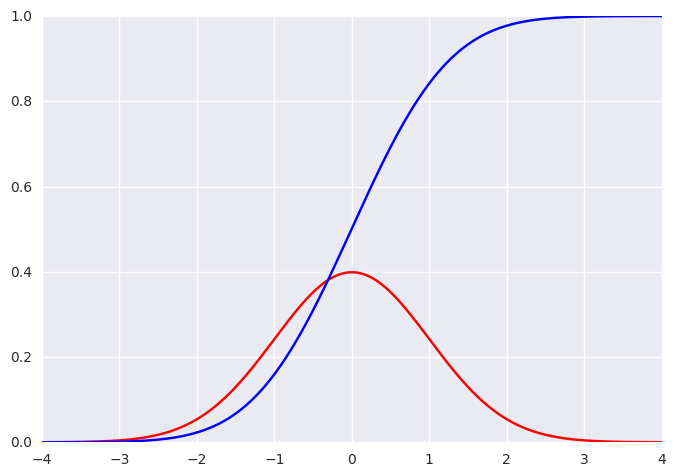

In [313]:
# Let us test the implementation
from scipy.stats import norm

x = np.linspace(-4, 4, 1000)
mu = 0
sigma = 1

pmf, cmf = gaussian(x, mu, sigma)

plt.figure(0)
plt.plot(x, pmf, 'r')
plt.plot(x, cmf, 'b')

# Ensure that our implementation makes sense
print(np.linalg.norm(pmf - norm.pdf(x, mu, sigma)))
print(np.linalg.norm(cmf - norm.cdf(x, mu, sigma)))

In [314]:
def match_hist_to_gauss(img, num_gl, mu, sigma):
    """Performs a histogram matching on the input image.
    
    Args:
        img: MxN numpy array of int. Input image that is to be transformed.
        num_gl: int. Number of graylevels in input image.
        mu: float. Desired mean of the matched normal distribution.
        sigma: float. Desired standard deviation of the matched normal distribution.
        
    Returns:
        trans_img: MxN numpy array of int. Histogram transformed image.
    """
    
    # Get the histogram-equalized image, and the transform from the function we made above
    histeq_img, histeq_trans = histeq(img, num_gl)
    
    # Get the desired probability mass function and cumulative mass function
    # (in this case from the Gaussian distribution). It is rather important
    # that the length of the pmf and cmf is of size num_gl such that there
    # is one value for each graylevel
    x = np.linspace(0, num_gl-1, num_gl)
    norm_pmf, norm_cmf = gaussian(x, mu, sigma)
    
    # Create a new mapping from the histeq to the wanted image
    norm_map = np.round((num_gl - 1)*norm_cmf)
    inv_norm_map = np.array([int(np.argmin(np.abs(norm_map - histeq_trans[g]))) for g in range(num_gl)])
    
    # More verbose version of the list comprehension above (note that np.argmin returns the smallest
    # index if there are more than one):
    # inv_norm_map = np.zeros(num_gl)
    #for g in range(num_gl):
    #   closest_index = int(np.argmin(np.abs(norm_map - histeq_trans[g])))
    #   inv_norm_map[g] = closest_index
    
    # Create a new image based on this transform
    trans_img = inv_norm_map[histeq_img.astype(np.uint8)]
    trans_img = np.zeros_like(histeq_img)
    
    for ind, val in enumerate(histeq_trans):
        trans_img[histeq_img==val] = inv_norm_map[ind]
    
    # Scale it back to original value range (assumed here to be [0, 255])
    
    #return 255*(np.max(trans_img) - trans_img)/(np.max(trans_img) - np.min(trans_img))
    return trans_img

Let us test it with the car image from earlier

In [315]:
mu = 128
sigma = 30
num_gl = 256
norm_img = match_hist_to_gauss(img, num_gl, mu, sigma)

(-0.5, 255.5, 255.5, -0.5)

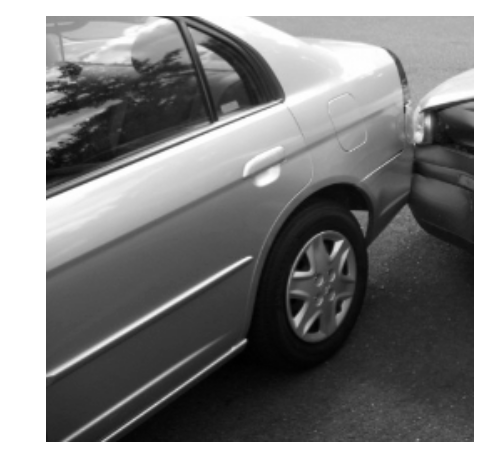

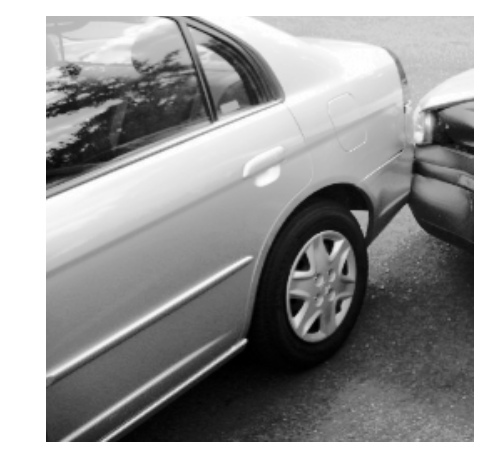

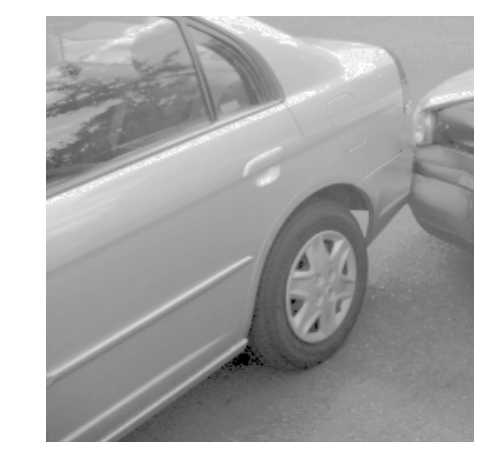

In [319]:
# Compare images
plt.figure(0)
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.figure(1)
plt.imshow(histeq_img, cmap='gray')
plt.axis('off')
plt.figure(2)
plt.imshow(norm_img, cmap='gray')
plt.axis('off')

<Container object of 256 artists>

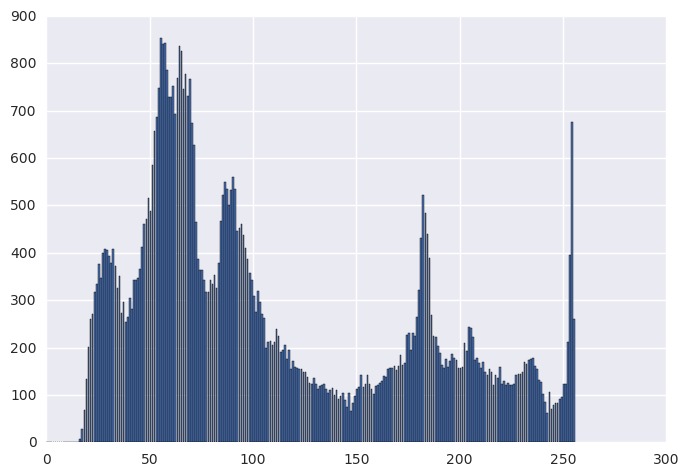

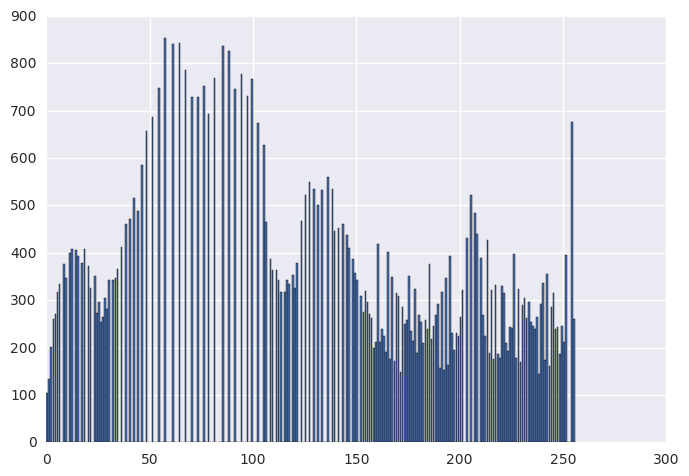

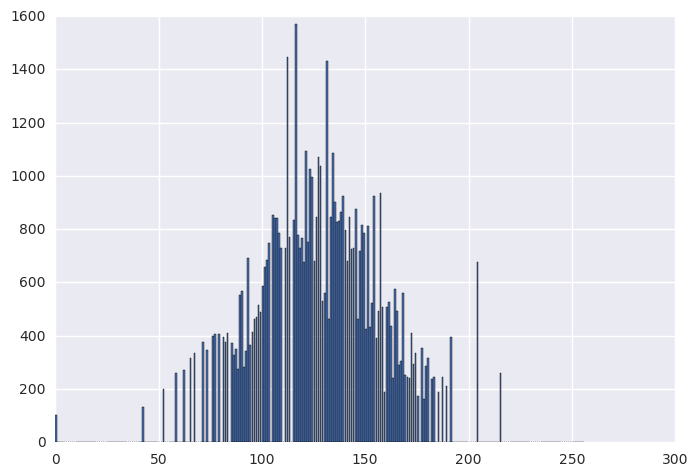

In [321]:
# Compare histograms
orig_hist, _ = np.histogram(img, bins=256, range=(0, 256))
norm_hist, _ = np.histogram(norm_img, bins=256, range=(0, 256))

plt.figure(0)
plt.bar(range(0, 256), orig_hist)
plt.figure(1)
plt.bar(range(0, 256), histeq_hist)
plt.figure(2)
plt.bar(range(0, 256), norm_hist)